In [1]:
# imports needed for EDA on Fashion Products Dataset
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# visualization settings
%matplotlib inline
sns.color_palette(palette='Set3')

# path settings
csv_path = "../data/styles.csv"
img_base_path = "../data/images/"

# Exploratory Data Analysis on Fashion Products Dataset

In [2]:
# create pandas dataframe from csv
df = pd.read_csv(csv_path, on_bad_lines="skip")

In [3]:
# create SQLite database connection
conn = sqlite3.connect('fashion_products.db')
df.to_sql('fashion_products', conn, if_exists='replace', index=False)
db_table = 'fashion_products'
cursor = conn.cursor() # Get a cursor object to interact/run SQL queries

## EDA Statistics using SQLite

Get schema info using "PRAGMA table_info(your_table_name);"
It retrieves information about the columns in the specified table, including column names, data types, and constraints.
What you get:
 - Column order (cid)
 - Column name (name)
 - Data type (type)
 - Not Null flag (notnull)
 - Default value (dflt_value)
 - Primary key flag (pk)

In [4]:
# get basic statistics from the database using SQL
cursor.execute(f"PRAGMA table_info({db_table});")
columns_info = cursor.fetchall() # Get all rows from last executed query as list of tuples

# print
columns_info

[(0, 'id', 'INTEGER', 0, None, 0),
 (1, 'gender', 'TEXT', 0, None, 0),
 (2, 'masterCategory', 'TEXT', 0, None, 0),
 (3, 'subCategory', 'TEXT', 0, None, 0),
 (4, 'articleType', 'TEXT', 0, None, 0),
 (5, 'baseColour', 'TEXT', 0, None, 0),
 (6, 'season', 'TEXT', 0, None, 0),
 (7, 'year', 'REAL', 0, None, 0),
 (8, 'usage', 'TEXT', 0, None, 0),
 (9, 'productDisplayName', 'TEXT', 0, None, 0)]

SELECT
    - The SELECT statement is used to fetch data from a table in your database.
    - You can specify which columns to get, and how many rows, and filter/search using WHERE.

    Examples:
    Select all columns and rows:
        SELECT * FROM my_table;
    (The * means “all columns”.)

    Select specific columns:
        SELECT name, price FROM my_table;

    Select with a filter:
        SELECT name, price FROM my_table WHERE category = 'Shoes';

COUNT
    - COUNT is an aggregate function that counts the number of rows that match a query.
    - It is often used with SELECT to find out “how many…?”
    
    Examples:
    Count all rows in a table:
        SELECT COUNT(*) FROM my_table;
    (How many rows are in my_table?)

    Count rows that match a condition:
        SELECT COUNT(*) FROM my_table WHERE price > 50;
    (How many items cost more than 50?)
    
    Count rows for each group:
        SELECT category, COUNT(*) FROM my_table GROUP BY column;
    (How many items are in each column?)

In [5]:
# get count of non-null entries per column
columns = [col[1] for col in columns_info]  # Extract column names from PRAGMA output
count_selects = ", ".join([f"COUNT({col}) AS {col}_count" for col in columns]) # Create COUNT() select statements / COUNT(column) ignores NULLs.
cursor.execute(f"SELECT {count_selects} FROM {db_table};")
counts = cursor.fetchone()  # Fetch the single row result

# print counts per column
print("Non-null counts per column:")
for col, count in zip(columns, counts):
    print(f"{col}: {count}")

Non-null counts per column:
id: 44424
gender: 44424
masterCategory: 44424
subCategory: 44424
articleType: 44424
baseColour: 44409
season: 44403
year: 44423
usage: 44107
productDisplayName: 44417


In [6]:
# get count of unique entries per column
unique_selects = ", ".join([f"COUNT(DISTINCT {col}) AS {col}_unique_count" for col in columns]) # Create COUNT(DISTINCT) select statements
cursor.execute(f"SELECT {unique_selects} FROM {db_table};")
unique_counts = cursor.fetchone()  # Fetch the single row result

# print unique counts per column
print("\nUnique counts per column:")
for col, unique_count in zip(columns, unique_counts):
    print(f"{col}: {unique_count}")


Unique counts per column:
id: 44424
gender: 5
masterCategory: 7
subCategory: 45
articleType: 143
baseColour: 46
season: 4
year: 13
usage: 8
productDisplayName: 31121


1. FROM
    - Specifies the table you want to query data from.

    Example:
        SELECT * FROM products


2. WHERE
    - Filters rows to include only those that meet a specified condition.

    Example:
        SELECT * FROM products WHERE price > 100


3. GROUP BY
    - Groups rows that have the same values in specified columns, letting you calculate aggregates (like COUNT, SUM) for each group.

    Example:
        SELECT category, COUNT(*) FROM products GROUP BY category


4. HAVING
    - Filters groups (after GROUP BY) based on an aggregate function result (like only showing groups with more than 10 items).

    Example:
        SELECT category, COUNT(*) FROM products GROUP BY category HAVING COUNT(*) > 10

        
5. COUNT
    - An aggregate function that counts the number of rows (or non-null values) in each group or the whole result.

    Example (with GROUP BY):
        SELECT brand, COUNT(*) FROM products GROUP BY brand

    Example (all rows):
        SELECT COUNT(*) FROM products WHERE price > 100


6. ORDER BY
    - Sorts the result by one or more columns, ascending (ASC) or descending (DESC).
    Example:
        SELECT * FROM products ORDER BY price DESC

In [7]:
# check for null rows in the database
where_clause = " AND ".join([f"{col} IS NULL" for col in columns]) # Build WHERE clause: col1 IS NULL AND col2 IS NULL AND ...
cursor.execute(f"SELECT COUNT(*) FROM {db_table} WHERE {where_clause};")
null_rows = cursor.fetchone()

# print
print(f"Number of fully-null rows: {null_rows[0]}")

# if there are any fully-null rows, delete them
if null_rows[0] > 0:
    cursor.execute(f"DELETE FROM {db_table} WHERE {where_clause};")
    conn.commit()  # Commit the changes to the database
    print(f"Deleted {null_rows[0]} fully-null rows from the database.")

Number of fully-null rows: 0


In [8]:
# check for missing values per column using SQL
where_clause = " OR ".join([f"{col} IS NULL" for col in columns]) # Create WHERE clause: col1 IS NULL OR col2 IS NULL OR ...
cursor.execute(f"SELECT COUNT(*) FROM {db_table} WHERE {where_clause};")
null_anywhere = cursor.fetchone()

#print
print(f"Number of rows with any missing (NULL) value: {null_anywhere[0]}")

# if there are any rows with missing values, drop them
if null_anywhere[0] > 0:
    cursor.execute(f"DELETE FROM {db_table} WHERE {where_clause};")
    conn.commit()  # Commit the changes to the database
    print(f"Dropped {null_anywhere[0]} rows with missing values from the database.")

Number of rows with any missing (NULL) value: 347
Dropped 347 rows with missing values from the database.


In [9]:
# check for duplicate rows WORKS CORRECTLY WHEN NULL ROWS AND FULLY-NULL ROWS ARE REMOVED
distinct_expressions = " || '-' || ".join([f"{col}" for col in columns])
cursor.execute(f"SELECT COUNT(*) - COUNT(DISTINCT {distinct_expressions}) AS duplicate_count FROM {db_table};")
num_duplicates = cursor.fetchone()[0]

# print number of duplicate rows
print(f"\nNumber of duplicate rows in the table: {num_duplicates}")

# Step 1: Find all group values that are duplicated (i.e. have count > 1)
if num_duplicates > 0:
    print("Duplicates found. Removing duplicates...")
    # Exclude 'id' column from GROUP BY if it is primary key
    group_by_cols = [col for col in columns if col.lower() != "id"]
    col_expr = ", ".join(group_by_cols)
    
    # Remove all but the first occurrence of each unique group
    delete_query = f"""
    DELETE FROM {db_table}
    WHERE rowid NOT IN (
        SELECT MIN(rowid)
        FROM {db_table}
        GROUP BY {col_expr}
    )
    """
    cursor.execute(delete_query)
    conn.commit()
    print("Duplicates removed.")

else:
    print("No duplicate rows found.")

# Optionally, verify result
cursor.execute(f"""
    SELECT COUNT(*) - COUNT(DISTINCT {distinct_expressions})
    FROM {db_table}
""")
still_dupes = cursor.fetchone()[0]
print(f"Number of duplicate rows after cleanup: {still_dupes}")


Number of duplicate rows in the table: 0
No duplicate rows found.
Number of duplicate rows after cleanup: 0


In [10]:
# find rare category values in each categorical column
categorical_cols = [col[1] for col in columns_info if col[2] == 'TEXT'] # get list of categorical columns from columns_info
categorical_cols.remove('productDisplayName') # skip productDisplayName as it has too many unique values
rare_threshold = 20  # define threshold for rarity
for col in categorical_cols:
    cursor.execute(f"""
        SELECT {col}, COUNT(*) as freq
        FROM {db_table}
        GROUP BY {col}
        HAVING freq < {rare_threshold}
        ORDER BY freq ASC
    """)
    rare_values = cursor.fetchall()
    # print rare values for the column that are under 10 occurrences
    # only print if there are any rare values
    if rare_values:
        print(f"\nRare values in column '{col}':")
        for value, freq in rare_values:
            print(f"{value}: {freq}")


Rare values in column 'masterCategory':
Home: 1

Rare values in column 'subCategory':
Home Furnishing: 1
Vouchers: 1
Beauty Accessories: 3
Sports Accessories: 3
Shoe Accessories: 4
Wristbands: 4
Perfumes: 6
Umbrellas: 6
Water Bottle: 7
Bath and Body: 9
Hair: 19

Rare values in column 'articleType':
Body Wash and Scrub: 1
Cushion Covers: 1
Hair Accessory: 1
Ipad: 1
Mens Grooming Kit: 1
Shoe Laces: 1
Suits: 1
Face Serum and Gel: 2
Key chain: 2
Makeup Remover: 2
Ties and Cufflinks: 2
Toner: 2
Beauty Accessory: 3
Body Lotion: 3
Hat: 3
Lounge Tshirts: 3
Shoe Accessories: 3
Tablet Sleeve: 3
Trolley Bag: 3
Eye Cream: 4
Face Scrub and Exfoliator: 4
Lehenga Choli: 4
Lip Plumper: 4
Robe: 4
Nehru Jackets: 5
Nail Essentials: 6
Shrug: 6
Umbrellas: 6
Headband: 7
Lip Care: 7
Rain Jacket: 7
Salwar and Dupatta: 7
Wristbands: 7
Blazers: 8
Clothing Set: 8
Footballs: 8
Shapewear: 9
Tights: 9
Mask and Peel: 10
Concealer: 11
Rucksacks: 11
Water Bottle: 11
Booties: 12
Mascara: 12
Rompers: 12
Basketballs: 13

In [11]:
# Value Distributions for each categorical column
for col in categorical_cols:
    cursor.execute(f"""
        SELECT {col}, COUNT(*) as freq
        FROM {db_table}
        GROUP BY {col}
        ORDER BY freq DESC
        LIMIT 10
    """)
    value_counts = cursor.fetchall()
    print(f"\nValue distribution for column '{col}':")
    for value, freq in value_counts:
        print(f"{value}: {freq}")


Value distribution for column 'gender':
Men: 22109
Women: 18357
Unisex: 2126
Boys: 830
Girls: 655

Value distribution for column 'masterCategory':
Apparel: 21366
Accessories: 11244
Footwear: 9197
Personal Care: 2139
Free Items: 105
Sporting Goods: 25
Home: 1

Value distribution for column 'subCategory':
Topwear: 15387
Shoes: 7323
Bags: 3053
Bottomwear: 2686
Watches: 2542
Innerwear: 1806
Jewellery: 1079
Eyewear: 1073
Fragrance: 1001
Sandal: 961

Value distribution for column 'articleType':
Tshirts: 7066
Shirts: 3214
Casual Shoes: 2845
Watches: 2542
Sports Shoes: 2016
Kurtas: 1844
Tops: 1762
Handbags: 1759
Heels: 1323
Sunglasses: 1073

Value distribution for column 'baseColour':
Black: 9700
White: 5497
Blue: 4907
Brown: 3440
Grey: 2735
Red: 2434
Green: 2103
Pink: 1824
Navy Blue: 1784
Purple: 1612

Value distribution for column 'season':
Summer: 21440
Fall: 11414
Winter: 8511
Spring: 2712

Value distribution for column 'usage':
Casual: 34397
Sports: 4004
Ethnic: 3208
Formal: 2345
Smart C

In [12]:
# trend analysis over years for 'season' column
cursor.execute(f"""
    SELECT year, season, COUNT(*) as freq
    FROM {db_table}
    GROUP BY year, season
    ORDER BY year ASC, season ASC
""")
trends = cursor.fetchall()

# print trends
print("\nTrends of 'season' over years:")
for year, season, freq in trends:
    print(f"Year: {year}, Season: {season}, Frequency: {freq}")



Trends of 'season' over years:
Year: 2007.0, Season: Spring, Frequency: 2
Year: 2008.0, Season: Fall, Frequency: 1
Year: 2008.0, Season: Spring, Frequency: 3
Year: 2008.0, Season: Summer, Frequency: 2
Year: 2008.0, Season: Winter, Frequency: 1
Year: 2009.0, Season: Fall, Frequency: 19
Year: 2009.0, Season: Summer, Frequency: 1
Year: 2010.0, Season: Fall, Frequency: 640
Year: 2010.0, Season: Spring, Frequency: 3
Year: 2010.0, Season: Summer, Frequency: 133
Year: 2010.0, Season: Winter, Frequency: 70
Year: 2011.0, Season: Fall, Frequency: 8727
Year: 2011.0, Season: Spring, Frequency: 80
Year: 2011.0, Season: Summer, Frequency: 4671
Year: 2011.0, Season: Winter, Frequency: 156
Year: 2012.0, Season: Fall, Frequency: 1883
Year: 2012.0, Season: Spring, Frequency: 131
Year: 2012.0, Season: Summer, Frequency: 13111
Year: 2012.0, Season: Winter, Frequency: 1143
Year: 2013.0, Season: Fall, Frequency: 71
Year: 2013.0, Season: Spring, Frequency: 365
Year: 2013.0, Season: Summer, Frequency: 718
Ye

In [13]:
# close the database connection
conn.close()

## EDA Statistics using Pandas

In [14]:
# display first 5 rows
df.head(5) # display first 5 rows

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [15]:
# get basic info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [16]:
# describe the dataframe to get statistical summary
df.describe(include='all')

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
count,44424.000000,44424,44424,44424,44424,44409,44403,44423.000000,44107,44417
unique,NaN,5,7,45,143,46,4,NaN,8,31121
top,NaN,Men,Apparel,Topwear,Tshirts,Black,Summer,NaN,Casual,Lucera Women Silver Earrings
freq,NaN,22147,21397,15402,7067,9728,21472,NaN,34406,82
mean,29696.334301,NaN,NaN,NaN,NaN,NaN,NaN,2012.806497,NaN,NaN
std,17049.490518,NaN,NaN,NaN,NaN,NaN,NaN,2.126480,NaN,NaN
min,1163.000000,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,NaN,NaN
25%,14768.750000,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,NaN,NaN
50%,28618.500000,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN
75%,44683.250000,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,NaN


Obs: Only Categorical data in CSV

In [17]:
# get count of null rows
null_counts = df.isnull().sum()
print("Null counts per column:")
print(null_counts)

# if there are any null rows, drop them
if null_counts.sum() > 0:
    print(f"Dropping rows with any null values...")
    df = df.dropna()  # drop rows with any null values
else:
    print("No null values found.")

# print updated null counts
null_counts = df.isnull().sum()
print("Updated Null counts per column after dropping nulls:")
print(null_counts)

Null counts per column:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64
Dropping rows with any null values...
Updated Null counts per column after dropping nulls:
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64


In [18]:
# check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows in the dataframe: {duplicate_rows}")

# if there are any duplicate rows, drop them
if duplicate_rows > 0:
    print("Duplicates found. Removing duplicates...")
    df = df.drop_duplicates()
else:
    print("No duplicate rows found.")

# print updated duplicate row count
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows after cleanup: {duplicate_rows}")

Number of duplicate rows in the dataframe: 0
No duplicate rows found.
Number of duplicate rows after cleanup: 0


In [19]:
# Unique values inspection
df.nunique()

id                    44077
gender                    5
masterCategory            7
subCategory              45
articleType             142
baseColour               46
season                    4
year                     13
usage                     8
productDisplayName    30806
dtype: int64

In [20]:
# Display unique values per column except ID

# Get columns except 'id' & 'productDisplayName'
cols = [col for col in df.columns if (col != 'id' and col != 'productDisplayName')]

# 1. Get unique values for each column except ID
unique_values = [df[col].unique() for col in cols]

# 2. Find the maximum length
max_unique = max(len(u) for u in unique_values)

# 3. Pad each list for equal length
unique_values_padded = [list(u) + [pd.NA]*(max_unique - len(u)) for u in unique_values]

# 4. Create the DataFrame (without ID column)
unique_df = pd.DataFrame(data=dict(zip(cols, unique_values_padded)))

unique_df

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual
1,Women,Accessories,Bottomwear,Jeans,Blue,Summer,2012.0,Ethnic
2,Boys,Footwear,Watches,Watches,Silver,Winter,2016.0,Formal
3,Girls,Personal Care,Socks,Track Pants,Black,Spring,2017.0,Sports
4,Unisex,Free Items,Shoes,Tshirts,Grey,<NA>,2015.0,Smart Casual
...,...,...,...,...,...,...,...,...
137,<NA>,<NA>,<NA>,Mens Grooming Kit,<NA>,<NA>,<NA>,<NA>
138,<NA>,<NA>,<NA>,Makeup Remover,<NA>,<NA>,<NA>,<NA>
139,<NA>,<NA>,<NA>,Body Wash and Scrub,<NA>,<NA>,<NA>,<NA>
140,<NA>,<NA>,<NA>,Suits,<NA>,<NA>,<NA>,<NA>


       id  gender masterCategory       subCategory articleType baseColour  \
449  6845  Unisex    Accessories  Shoe Accessories  Shoe Laces      Black   

     season    year   usage                                 productDisplayName  
449  Summer  2011.0  Casual  Timberland Unisex Hiker Round Lace Shoe Access...  


(np.float64(-0.5), np.float64(59.5), np.float64(79.5), np.float64(-0.5))

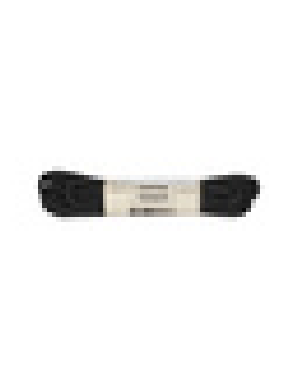

In [21]:
# Rare category inspection
rare_category = df['articleType'].value_counts().idxmin()
print(df[df['articleType'] == rare_category].head())

# Display an image from the rare category
img = mpimg.imread(f"{img_base_path}{df[df['articleType'] == rare_category]['id'].values[0]}.jpg")
plt.imshow(img)
plt.axis('off')

In [22]:
# Bad labels inspection in all columns
bad_labels = ['NA', 'none', 'nan', None, np.nan, '']
for col in cols:
    print(f"Column: {col}")
    for bad in bad_labels:
        count = (df[col] == bad).sum()
        if count > 0:
            print(f"  Bad label '{bad}': {count} occurrences")
    print()

Column: gender

Column: masterCategory

Column: subCategory

Column: articleType

Column: baseColour

Column: season

Column: year

Column: usage



In [23]:
# top 10 frequent values and their counts in each categorical column
for col in categorical_cols:
    print(f"\nTop 10 frequent values in column '{col}':")
    print(df[col].value_counts().head(20))



Top 10 frequent values in column 'gender':
gender
Men       22109
Women     18357
Unisex     2126
Boys        830
Girls       655
Name: count, dtype: int64

Top 10 frequent values in column 'masterCategory':
masterCategory
Apparel           21366
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

Top 10 frequent values in column 'subCategory':
subCategory
Topwear                     15387
Shoes                        7323
Bags                         3053
Bottomwear                   2686
Watches                      2542
Innerwear                    1806
Jewellery                    1079
Eyewear                      1073
Fragrance                    1001
Sandal                        961
Wallets                       925
Flip Flops                    913
Belts                         811
Socks                         698
Dress                         478
Loungewear 

## EDA Visualization using Pandas, MatplotLib & Seaborn

- Among categories, the one with largest meaniful classes is 'articleType'
- But count of classes in 'articleType' is high
- Let's take out classes that represent less than 5% for better visuallization and classification later on

In [24]:
# print total classes in articleType
print(f"Total classes in 'articleType': {df['articleType'].nunique()}")

# calculate cumulative percentage for articleType
article_type_counts = df['articleType'].value_counts()
article_type_cumperc = article_type_counts.cumsum() / article_type_counts.sum() * 100

# find classes that represent 95% of the data
significant_classes = article_type_cumperc[article_type_cumperc <= 95].index.tolist()
print(f"Number of significant classes in 'articleType' representing 95% of data: {len(significant_classes)}")

Total classes in 'articleType': 142
Number of significant classes in 'articleType' representing 95% of data: 53


In [25]:
# get new df for significant classes only
df_significant = df[df['articleType'].isin(significant_classes)]
df_significant['articleType'].nunique()

53

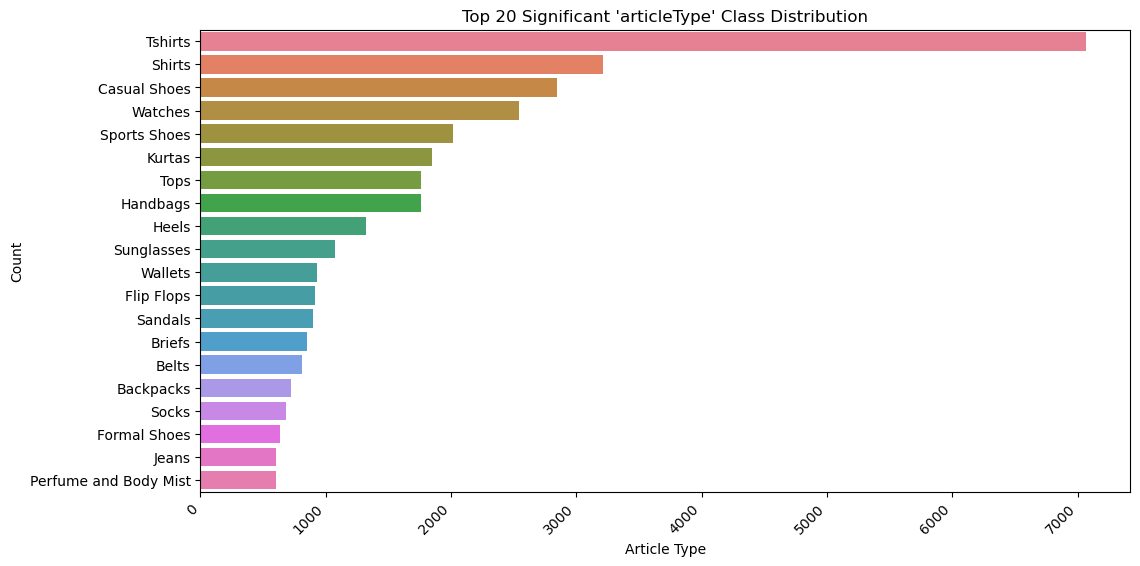

In [26]:
# filter dataframe to only include top 20 significant classes
top_20_counts = df_significant['articleType'].value_counts().head(20)

# visualize a horizontal bar plot of articleType class distribution for top 20 significant classes
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_counts.values, hue=top_20_counts.index, y=top_20_counts.index)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Significant 'articleType' Class Distribution")
plt.xlabel("Article Type")
plt.ylabel("Count")
plt.show()

# # visualize a pie chart of articleType class distribution for top 20 significant classes using seaborn
# plt.figure(figsize=(10, 8))
# sns.set_palette("Set3")
# plt.pie(top_20_counts.values, labels=top_20_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title("Top 20 Significant 'articleType' Class Distribution") 
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()

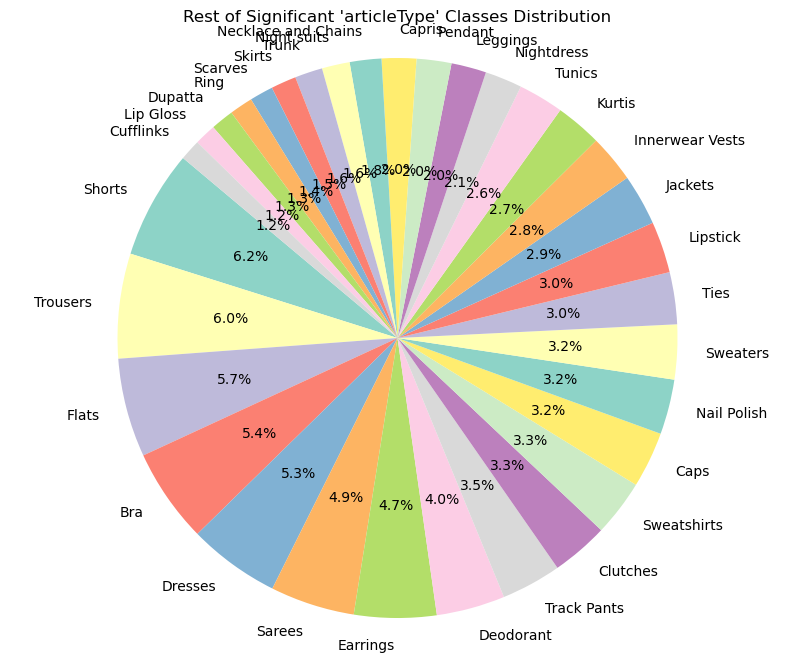

In [27]:
# filter dataframe to rest of classes other than top 20
rest_classes_count = df_significant['articleType'].nunique() - 20
rest_classes = df_significant['articleType'].value_counts().tail(rest_classes_count)

# visualize the rest of classes other than top 20 as 'Other' in pie chart
plt.figure(figsize=(10, 8))
sns.set_palette("Set3")
plt.pie(rest_classes.values, labels=rest_classes.index, autopct='%1.1f%%', startangle=140)
plt.title("Rest of Significant 'articleType' Classes Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [28]:
# Crosstab between gender and articleType
print("Crosstab between gender and articleType of significant classes:")
pd.crosstab(df_significant['gender'], df_significant['articleType']).head()

Crosstab between gender and articleType of significant classes:


articleType,Backpacks,Belts,Bra,Briefs,Capris,Caps,Casual Shoes,Clutches,Cufflinks,Deodorant,...,Sweatshirts,Ties,Tops,Track Pants,Trousers,Trunk,Tshirts,Tunics,Wallets,Watches
gender,,,,,,,,,,,,,,,,,,,,,
Boys,0,0,0,0,12,1,24,0,0,0,...,3,0,0,0,6,0,531,0,0,8
Girls,2,0,0,0,34,1,14,0,0,0,...,0,0,229,0,1,0,106,0,0,16
Men,55,541,0,562,0,113,2247,0,106,215,...,222,263,1,217,428,140,5242,1,442,1473
Unisex,631,9,0,0,0,142,227,0,0,3,...,1,0,0,1,0,0,71,0,21,143
Women,36,263,477,285,129,26,333,288,0,129,...,59,0,1532,86,95,0,1116,228,465,902


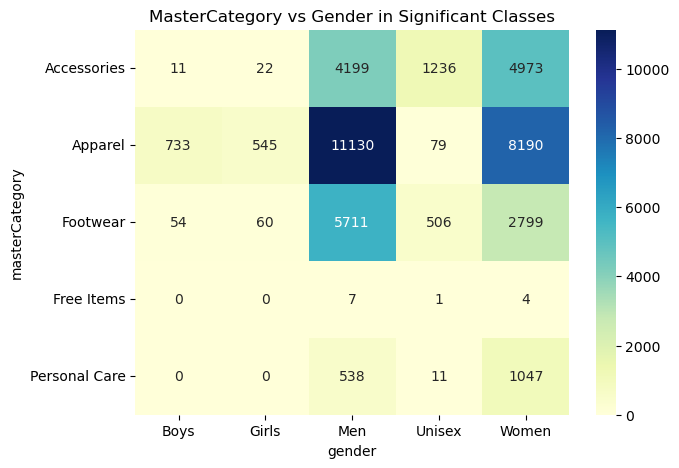

In [29]:
# Heatmap for MasterCategory vs Gender of the significant classes
ct = pd.crosstab(df_significant['masterCategory'], df_significant['gender'])
plt.figure(figsize=(7, 5))
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title('MasterCategory vs Gender in Significant Classes')
plt.show()

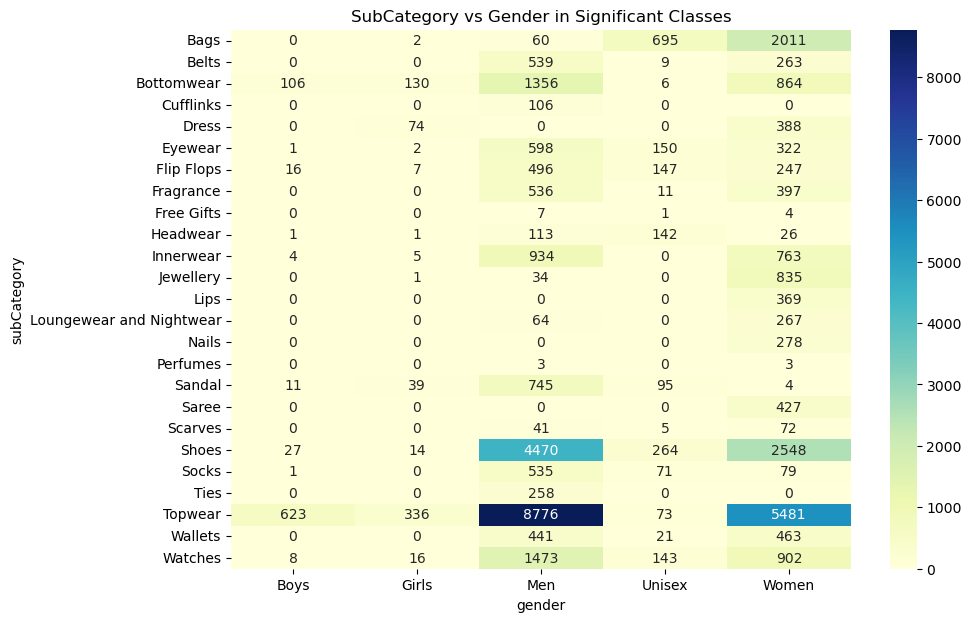

In [30]:
# heatmap for SubCategory vs Gender of the significant classes
ct = pd.crosstab(df_significant['subCategory'], df_significant['gender'])
plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title('SubCategory vs Gender in Significant Classes')
plt.show()

<Axes: xlabel='articleType'>

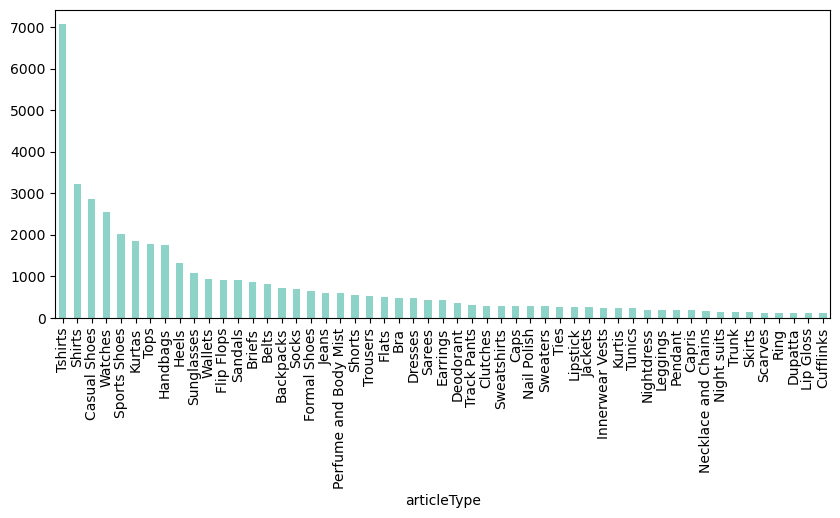

In [31]:
# bar plot for articleType distribution in significant classes
df_significant['articleType'].value_counts().plot(kind='bar', figsize=(10,4))

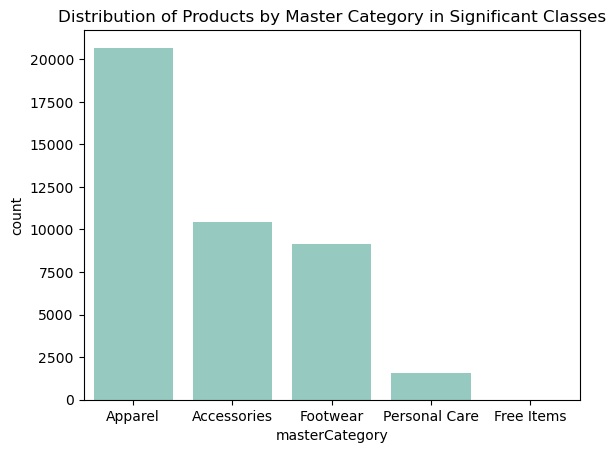

In [32]:
# bar plot for masterCategory distribution in significant classes
sns.countplot(x='masterCategory', data=df_significant)
plt.title('Distribution of Products by Master Category in Significant Classes')
plt.show()

C:\Users\Aishu\AppData\Local\Temp\ipykernel_17088\2856367367.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


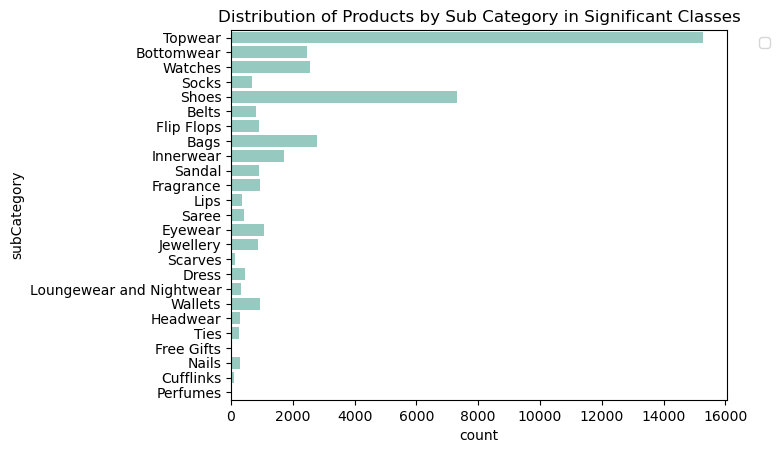

In [33]:
# bar plot for subCategory distribution in significant classes
sns.countplot(y='subCategory', data=df_significant)
plt.title('Distribution of Products by Sub Category in Significant Classes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

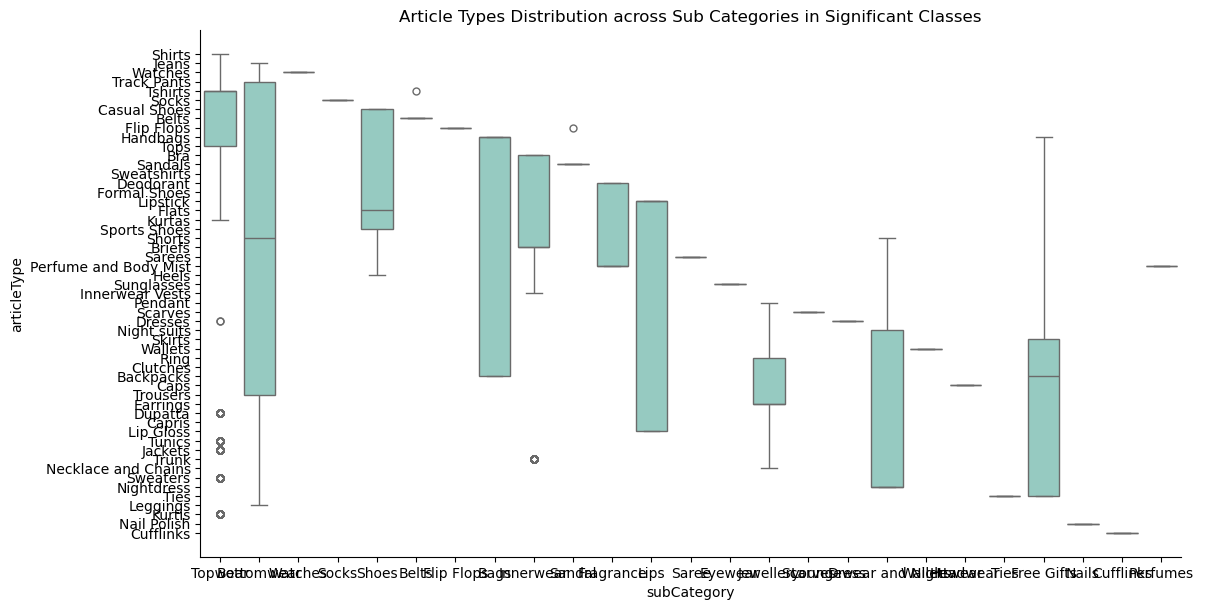

In [34]:
# box plot for articleType distribution across subCategory
sns.catplot(x='subCategory', y='articleType', data=df_significant, kind='box', height=6, aspect=2)
plt.title('Article Types Distribution across Sub Categories in Significant Classes')
plt.show()

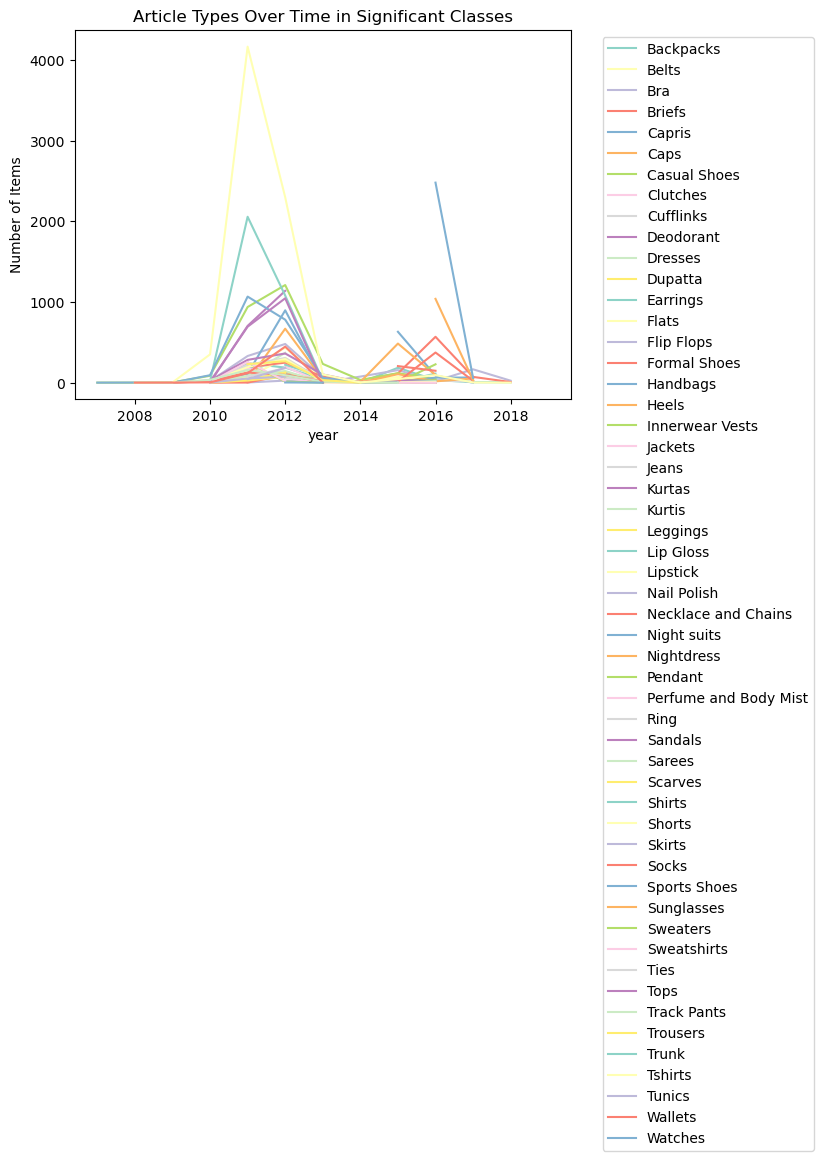

In [35]:
# Trend of article types over years in significant classes
df_significant.groupby(['year', 'articleType']).size().unstack().plot(kind='line')
plt.title('Article Types Over Time in Significant Classes')
plt.ylabel('Number of Items')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

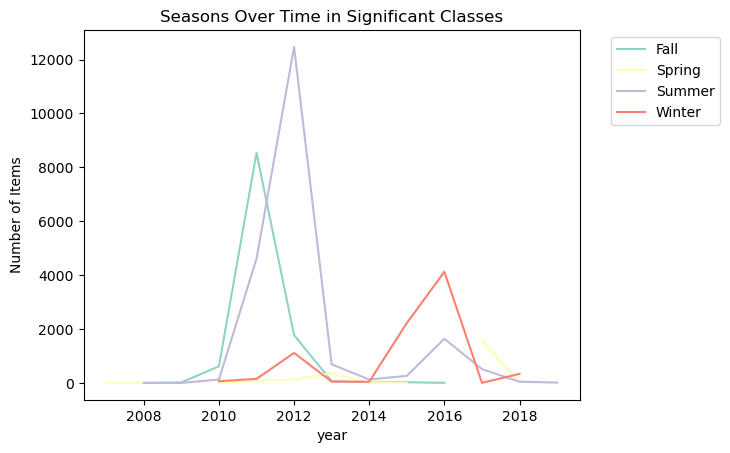

In [36]:
# Trend of seasons over years in significant classes
df_significant.groupby(['year', 'season']).size().unstack().plot(kind='line')
plt.title('Seasons Over Time in Significant Classes')
plt.ylabel('Number of Items')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

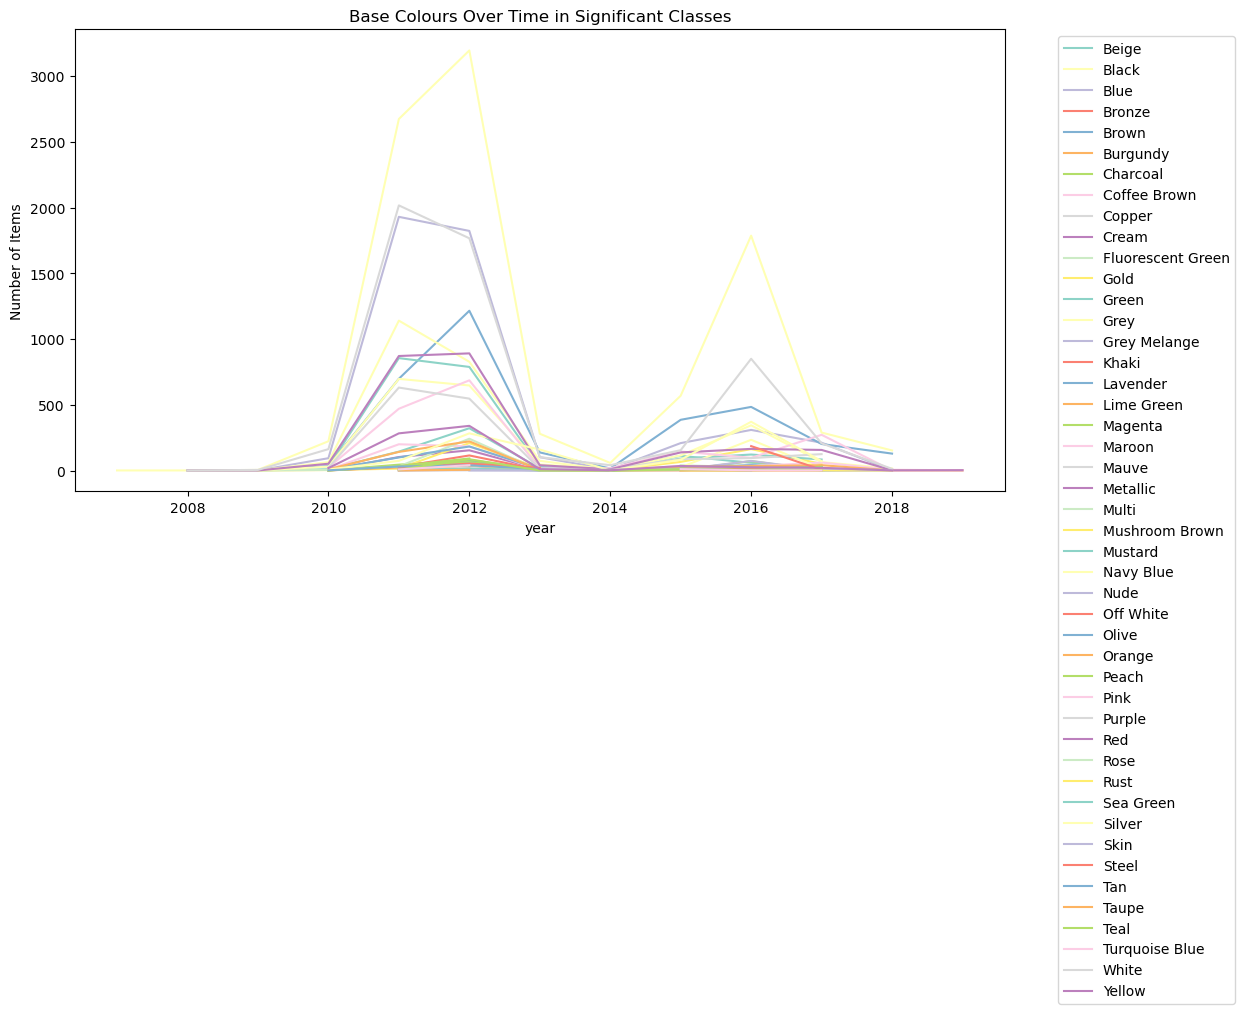

In [37]:
# Trend of colors over years in significant classes
df_significant.groupby(['year', 'baseColour']).size().unstack().plot(kind='line', figsize=(12,6))
plt.title('Base Colours Over Time in Significant Classes')
plt.ylabel('Number of Items')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### EDA - PCA for fun on signficant classes in articleType

In [38]:
# Prepare data for PCA
X = df_significant.drop(columns=['id', 'productDisplayName'])  # features are all other columns except 'id' and 'productDisplayName'
y = df_significant['articleType']  # target/label is 'articleType'

In [39]:
# Encode categorical variables and scale features
X_encoded = pd.get_dummies(X)  # Each unique value becomes a separate column
X_scaled = StandardScaler().fit_transform(X_encoded)  # Standardize features

In [40]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [41]:
# Make a DataFrame for easier plotting
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['articleType'] = y.values

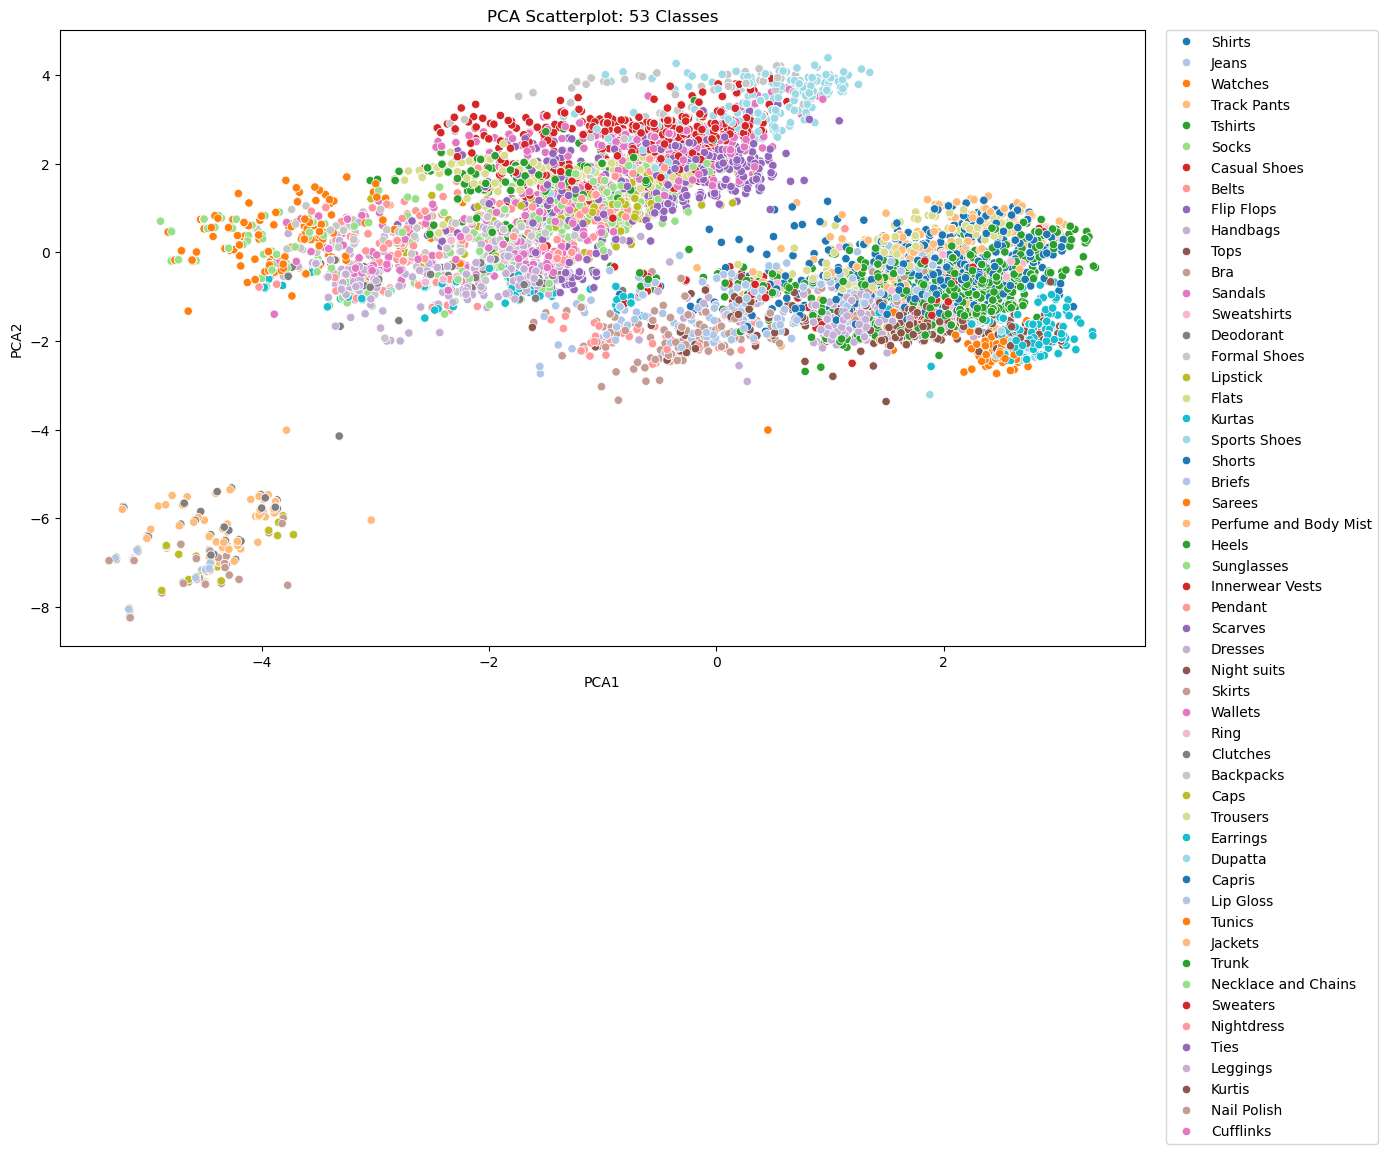

In [42]:
# Plot PCA results
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='articleType', palette='tab20', legend='brief')
plt.title(f"PCA Scatterplot: {len(df_pca['articleType'].unique())} Classes")
# Place the legend outside the plot on the right
plt.legend(
    bbox_to_anchor=(1.02, 1),   # (x, y) position (1.02 = a little right of axes)
    loc='upper left',           # which corner of legend box to use
    borderaxespad=0
)
plt.show()